<a href="https://colab.research.google.com/github/SGRGit/gwOsc/blob/master/CreateSampleSignalProc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import scipy

In [0]:
import matplotlib.pyplot as plt

In [0]:
import numpy as np

#Fs = 1e3;  # sampling rate
#Ts = 1.0/Fs; # sampling interval
#t = np.arange(0,1, Ts) # time vector

fs = 1e4
fr = np.float(50.0)
N = 1e3
fr = 100.0
t = np.arange(N) / fs

#t = np.linspace(0, 60, 50)
#a = 1e-18
a = 5
x = a*np.sin(2*np.pi*fr*t) + a*np.cos(2*np.pi*fr*t)
n = 1e2*np.random.randn(len(t))
xn = x + np.random.randn(len(t))

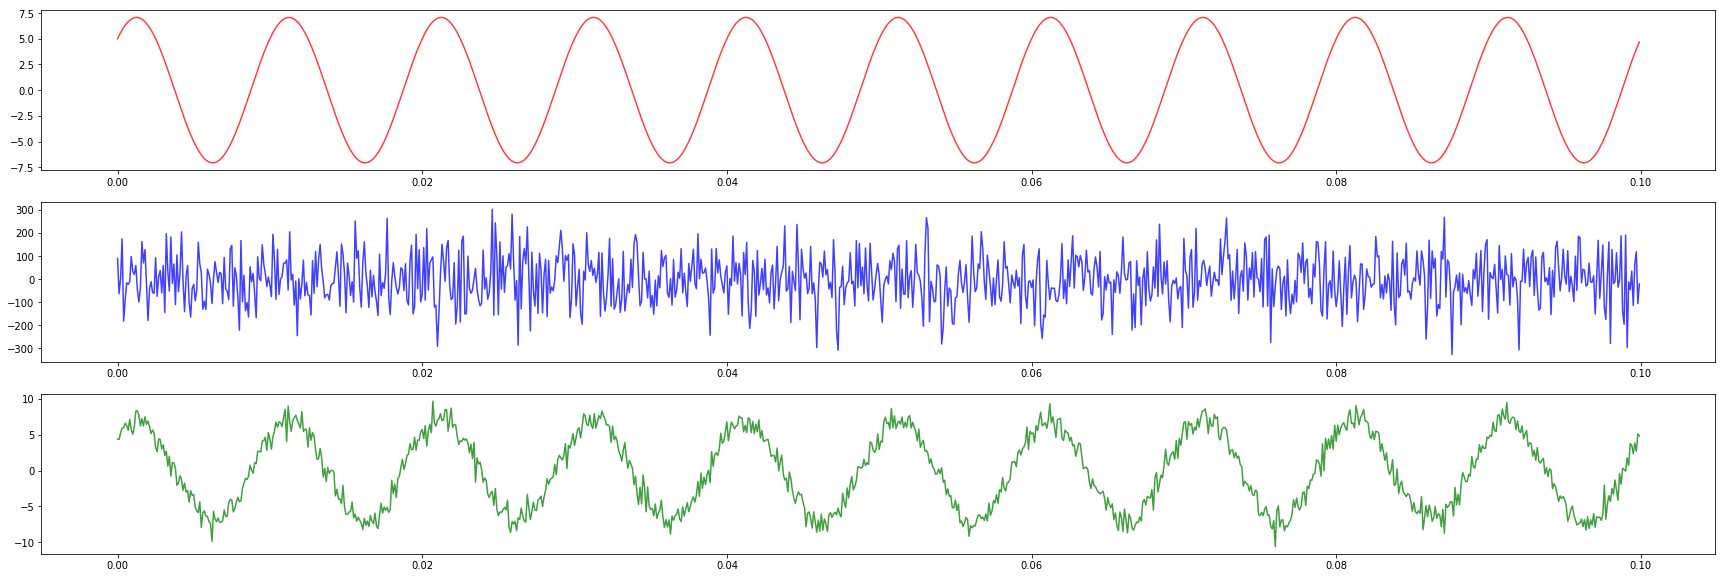

In [382]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1)
f.set_figwidth(30)
f.set_figheight(10)
ax1.plot(t, x, 'r' , alpha=0.75)

ax2.plot(t, n, 'b', alpha=0.75)

ax3.plot(t, xn, 'g', alpha=0.75)

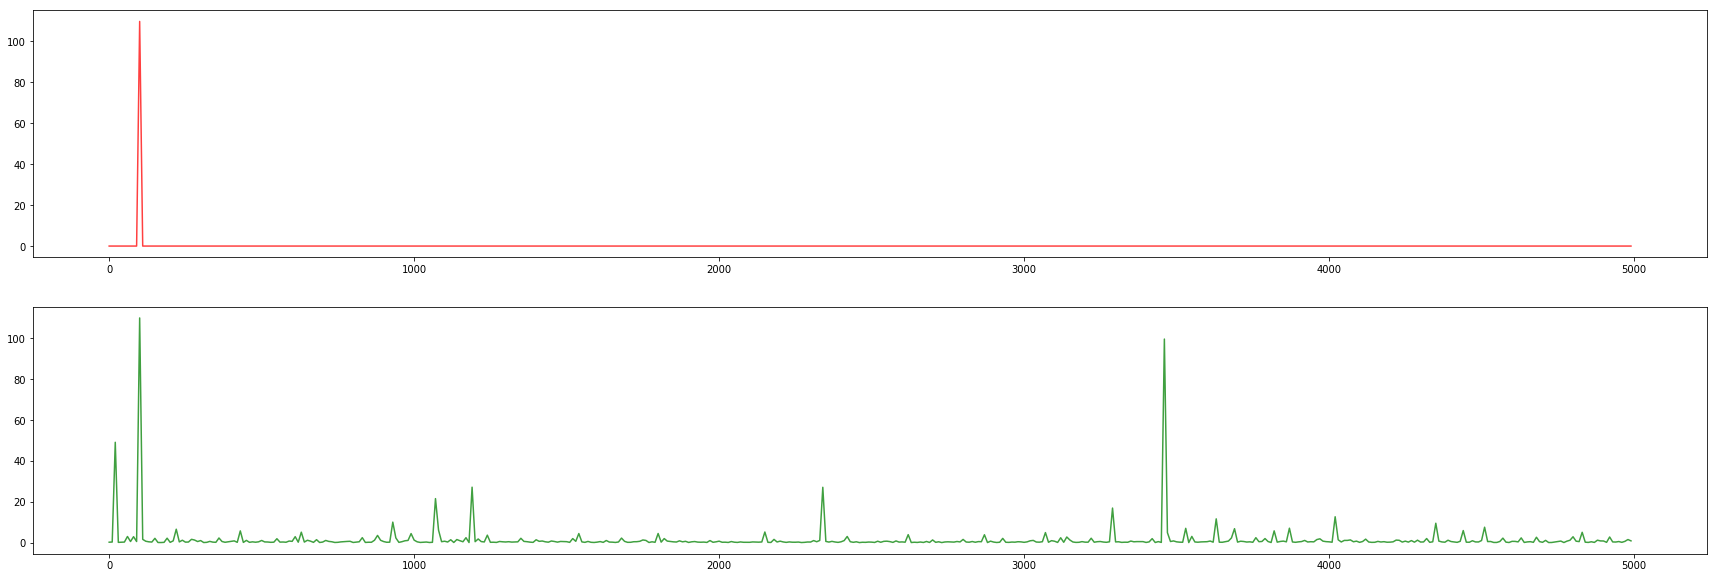

In [389]:
#noise + signal
s = len(xn) 
k = np.arange(s)
T = s/fs
frq = k/T # two sides frequency range
frq = frq[range(int(s/2))] # one side frequency range
Y = np.fft.fft(xn)/n # fft computing and normalization
Y = Y[range(int(s/2))]

# signal
ss = len(x) 
ks = np.arange(ss)
Ts = ss/fs
frqs = ks/T # two sides frequency range
frqs = frq[range(int(ss/2))] # one side frequency range
Ys = np.fft.fft(x)/n # fft computing and normalization
Ys = Ys[range(int(ss/2))]


#plt.plot(frq, abs(Y))

ft, (axft1, axft2) = plt.subplots(2, 1)
ft.set_figwidth(30)
ft.set_figheight(10)
axft1.plot(frqs, abs(Ys), 'r' , alpha=0.75)
axft2.plot(frq, abs(Y), 'g', alpha=0.75)
